# Problem 1: Learn Text Classification for Airline Tweet Classification

This data originally came from Crowd flower's Data for Everyone library. As the original source says, a sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service"). The data is a slightly reformatted version of the original source. It includes a CSV file. The code that does these transformations is available on GitHub. For example, it contains whether the sentiment of the tweets in this set was positive, neutral, or negative for six US airlines. Here are we interested into classifying the positive and negative tweets. Please use the TF-IDF as the feature extractor. You can perform additional analysis such as removing the stop words, etc.

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

## Load Data


In [2]:
# Loading data and picking important features
data = pd.read_csv('Tweets.csv')

In [3]:
data = data[['airline_sentiment', 'text']]

In [4]:
data.head(100)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
...,...,...
95,negative,"@VirginAmerica Is it me, or is your website do..."
96,negative,@VirginAmerica I can't check in or add a bag. ...
97,negative,@VirginAmerica - Let 2 scanned in passengers l...
98,negative,@virginamerica What is your phone number. I ca...


In [5]:
raw_data = data[data['airline_sentiment']!='neutral']

In [6]:
raw_data.head(100)

,airline_sentiment,text
1,positive,@VirginAmerica plus you've added commercials t...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
5,negative,@VirginAmerica seriously would pay $30 a fligh...
6,positive,"@VirginAmerica yes, nearly every time I fly VX..."
...,...,...
144,positive,@VirginAmerica you have amazing staff &amp; su...
145,negative,@VirginAmerica I paid the premium to fly you a...
146,negative,@VirginAmerica question: is it not possible to...
147,positive,Always have it together!!! You're welcome! RT ...


## Part 1: SVM

Let's Start with SVM. Please define a pipeline for text analysis by combining `TfidfVectorizer` and an `svm.LinearSVC` classifier. Let's try to add balanced weight to handle the class-imbalance issue. 

(a) Please also use cross validation to select the best tuning parameters C.

(b) Please compute the precision/recall, f1-score, and confusion matrix for the selected models. 


In [26]:
X = raw_data['text']
y = raw_data['airline_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=90)

In [27]:
tfidf = TfidfVectorizer(stop_words = 'english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
temp = tfidf.transform(raw_data['text'])
X_train_tfidf

<9232x10857 sparse matrix of type '<class 'numpy.float64'>'
	with 87500 stored elements in Compressed Sparse Row format>

In [28]:
# SCV classifier
from sklearn.svm import SVC, LinearSVC
rbf_svc = SVC()
rbf_svc.fit(X_train_tfidf, y_train)
linear_svc = LinearSVC()
linear_svc.fit(X_train_tfidf, y_train)

LinearSVC()

## Performance Evaluation

              precision    recall  f1-score   support

    negative       0.92      0.98      0.95      1851
    positive       0.89      0.65      0.75       458

    accuracy                           0.91      2309
   macro avg       0.91      0.81      0.85      2309
weighted avg       0.91      0.91      0.91      2309



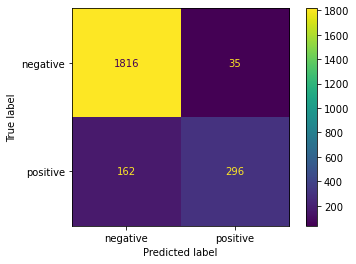

In [29]:
# custom function
from sklearn.metrics import classification_report, plot_confusion_matrix

def report(model):
    pred = model.predict(X_test_tfidf)
    print(classification_report(y_test, pred))
    plot_confusion_matrix(model, X_test_tfidf, y_test)


report(rbf_svc)

              precision    recall  f1-score   support

    negative       0.94      0.97      0.95      1851
    positive       0.85      0.76      0.80       458

    accuracy                           0.93      2309
   macro avg       0.90      0.86      0.88      2309
weighted avg       0.92      0.93      0.92      2309



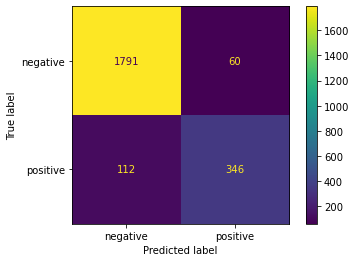

In [30]:
report(linear_svc)

In [31]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('scv', LinearSVC()),
])

In [32]:
# fit on entire data
pipe.fit(X, y)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('scv', LinearSVC())])

In [33]:
new_tweet = ['I did enjoy the flight']
pipe.predict(new_tweet)

array(['positive'], dtype=object)

In [34]:
new_tweet = ['I did take from NY to LA']
pipe.predict(new_tweet)

array(['negative'], dtype=object)

In [35]:
new_tweet = ['it just ok flight']
pipe.predict(new_tweet)

array(['negative'], dtype=object)

In [36]:
new_tweet = ['so so flight']
pipe.predict(new_tweet)

array(['negative'], dtype=object)

In [37]:
# For cross validation (CV) using Random Forest 
random_forest = RandomForestClassifier() 
max_depth=[2,4,8,16,32,64]
ntrees = [4,8,16,32]
max_features = [0.1,0.2,0.3,0.4,0.5]
parameters = {'max_depth':max_depth, 'n_estimators':ntrees,'max_features':max_features}
clf = GridSearchCV(random_forest,parameters, cv= 3,n_jobs=-1)
clf.fit(X_train_tfidf,y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 8, 16, 32, 64],
                         'max_features': [0.1, 0.2, 0.3, 0.4, 0.5],
                         'n_estimators': [4, 8, 16, 32]})

In [38]:
score = clf.score(X_test_tfidf,y_test)

# print best parameter after tuning 
print(f"Best Parameters are: {clf.best_params_}")  
print("\n---------------------------------\n")
print('Accuracy:{},Best parameters:{}, feature importance:{}'.format(score,clf.best_params_,clf.best_estimator_.feature_importances_))

Best Parameters are: {'max_depth': 64, 'max_features': 0.2, 'n_estimators': 32}

---------------------------------

Accuracy:0.8947596362061498,Best parameters:{'max_depth': 64, 'max_features': 0.2, 'n_estimators': 32}, feature importance:[0.00000000e+00 2.08328103e-05 3.42278169e-05 ... 0.00000000e+00
 2.98878449e-05 0.00000000e+00]



## Part 2: Please also explore using Logistic Regression on this problem and report the result. 

(a) Please plot the ROC curve and compute the area under the ROC curve. Please also use cross validation to select the best tuning parameters C. 

(b) Please plot the precision recall curve and compute the average precision. Can you choose an optimal threshold to maximum the F1-score?


In [39]:
temp=[]
for i in y_test:
    #print(i)
    if i=='negative':
        temp.append(0)
    elif i=='positive':
        temp.append(1)

y_test_binary=temp

In [40]:
Temp=[]
for i in y_train:
    #print(i)
    if i=='negative':
        Temp.append(0)
    elif i=='positive':
        Temp.append(1)
        
y_train=Temp


------------------------- part 1 -----------------------

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.960


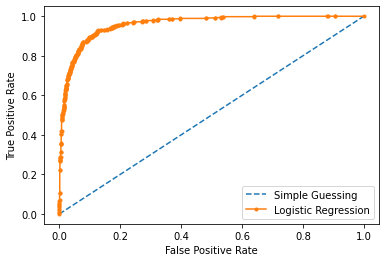


------------------------- part 2 -----------------------

Logistic: f1=0.797 auc=0.869


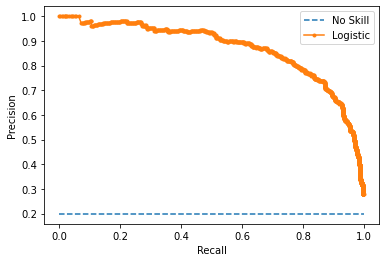


------------------------- part 3 -----------------------

 matthews_corrcoef = 0.7453818692331846

 Confusion Matrix: 
[[1708  143]
 [  60  398]]

 TN = 1708
 FP = 143
 FN = 60
 TP = 398
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      1851
           1       0.74      0.87      0.80       458

    accuracy                           0.91      2309
   macro avg       0.85      0.90      0.87      2309
weighted avg       0.92      0.91      0.91      2309



In [42]:
# Put your code here
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

print ("\n------------------------- part 1 -----------------------\n")



# instantiate model
model = LogisticRegression(class_weight='balanced',max_iter=2000)

# fit model
model.fit(X_train_tfidf, y_train)

ns_probs = [0 for _ in range(len(y_test_binary))]
lr_probs = model.predict_proba(X_test_tfidf)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test_binary, ns_probs)
lr_auc = roc_auc_score(y_test_binary, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr,_= roc_curve(y_test_binary, ns_probs)
lr_fpr, lr_tpr,_ = roc_curve(y_test_binary,lr_probs)

# plot the roc curve for the model
plt.figure(1)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Simple Guessing')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

print ("\n------------------------- part 2 -----------------------\n")

yhat = model.predict(X_test_tfidf)
lr_precision, lr_recall, _ = precision_recall_curve(y_test_binary, lr_probs)
lr_f1, lr_auc = f1_score(y_test_binary, yhat), auc(lr_recall, lr_precision)

#summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

temp=[]
for i in y_test_binary:
    if i==1:
        temp.append(i)

        
#plot the precision-recall curves
plt.figure(2)
no_skill = len(temp) / len(y_test_binary)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')

#axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')

#show the legend
plt.legend()

#show the plot
plt.show()

print ("\n------------------------- part 3 -----------------------\n")

model.score(X_test_tfidf, y_test_binary)
predicted = model.predict(X_test_tfidf)
expected = y_test_binary
mcc = matthews_corrcoef(expected, predicted)
CM = confusion_matrix(expected, predicted)
TN, FP, FN, TP = CM.ravel()

print (" matthews_corrcoef = " + str(mcc))
print(f"\n Confusion Matrix: \n{CM}")
print (f"\n TN = {TN}")
print (f" FP = {FP}")
print (f" FN = {FN}")
print (f" TP = {TP}")
print(classification_report(expected, predicted))

## Part 3 (Bonus 10 pts) 
Please select only the negative reviews and we aim to classify the reasons for the negative reviews. There are several potential reasons including 'Bad Flight', 'Late Flight', 'Customer Service Issue','Flight Booking Problems', 'Lost Luggage','Flight Attendant Complaints', 'Cancelled Flight','Damaged Luggage', 'longlines'.
       
Here, please choose one classification model (for example, random forest, SVM, etc ) to evaluate the performance. 


In [43]:
# Loading data and picking important features
data = pd.read_csv('Tweets.csv')
data.head(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)


In [44]:
negative_data = data[data['airline_sentiment']=='negative']
negative_data_known = negative_data[negative_data['negativereason']!="Can't Tell"]
raw_data_negative = negative_data_known[['negativereason','text']]
raw_data_negative

raw_data_negative['negativereason'].unique()

array(['Bad Flight', 'Late Flight', 'Customer Service Issue',
       'Flight Booking Problems', 'Lost Luggage',
       'Flight Attendant Complaints', 'Cancelled Flight',
       'Damaged Luggage', 'longlines'], dtype=object)

In [45]:
# Put your code here